In [1]:
import pandas as pd
from yahooquery import Ticker #pip install yahooquery
import datetime

import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [2]:
#A function that has only the stock exchange name of the company as an argument, and returns a data frame with 
# financial indicators such as InvestingCashFlow, TotalRevenue, TotalExpenses, TotalOperatingIncomeAsReported, 
# SellingGeneralAndAdministration, ProfitabilityIndex, HighestCosts, SellingGeneralAndAdministration%Revenue
# Retrieves data from the Yahoo Finance website using the yahooquery
# The function also includes currency conversion to USD if the data is different from the current exchange rate.
def finance_analys(ticker):
    #Loading data for a specific company
    YQ_aapl = Ticker(str(ticker))
    #Collecting the financial data
    methods = ['cash_flow', 'balance_sheet', 'income_statement']
    #Create one big dataset with all indicators
    df = pd.DataFrame()
    for method in methods:
        method
        df_tmp = getattr(YQ_aapl, method)()
        df_tmp.set_index(['asOfDate'], inplace=True)
        df_tmp=df_tmp.T
        df=df.append(df_tmp)
    df=df.T
    df.reset_index(inplace=True)
    #Removing duplicate columns
    df = df.loc[:,~df.columns.duplicated()].copy()
    
    #Currency conversion
    #In this piece of code, I retrieve the current currency exchange rate from the previous day. 
    #I check the currency in which the data is, if other than USD, I convert the currency, and if in USD, I leave it unchanged.
    date = datetime.date.today()-datetime.timedelta(days = 1)
    from_Unit=df['currencyCode'][1]
    to_Unit='USD'
    if from_Unit!='USD':
        exchange = pd.read_html(f'https://www.xe.com/currencytables/?from={from_Unit}&date={date}#table-section')[0]
        exchange['Date'] = date
        new_currency=exchange[exchange['Currency']==to_Unit]
        for i in df.iloc[:,3:]:
            df[i]*=new_currency.iloc[0, 2]
        df['currencyCode']='USD'
    elif from_Unit=='USD':
        df=df
    else:
        print('Unknown currency')
        
    #In this part of the function, I select only the necessary indicators from the entire data frame ( InvestingCashFlow, 
    #TotalRevenue, TotalExpenses, TotalOperatingIncomeAsReported, SellingGeneralAndAdministration) and enumerate 
    #those that are not in the data like ProfitabilityIndex, HighestCosts, SellingGeneralAndAdministration%Revenue
    df_finance=df[['asOfDate', 'periodType', 'currencyCode','InvestingCashFlow', 'TotalRevenue', 'TotalExpenses', 
                   'TotalOperatingIncomeAsReported', 'SellingGeneralAndAdministration']]
    for i in df_finance.iloc[:,3:]:
        df_finance[i]=df_finance[i].astype('float')
    df_finance['ProfitabilityIndex']=df_finance['TotalRevenue']/df_finance['TotalOperatingIncomeAsReported']
    df_finance['HighestCosts']=(df_finance['TotalExpenses']/df_finance['TotalRevenue'])*100
    df_finance['SellingGeneralAndAdministration%Revenue']=(df_finance['SellingGeneralAndAdministration']/df_finance['TotalRevenue'])*100
    df_finance['Company']=ticker
 
    return df_finance

## Getting data

In [3]:
#Downloading data for selected companies
nestle=finance_analys('NSRGY')
pepsico=finance_analys('PEP')
unliver=finance_analys('UL')

C:\Users\Karolina\AppData\Local\Temp\ipykernel_15620\1225988723.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df_tmp)
C:\Users\Karolina\AppData\Local\Temp\ipykernel_15620\1225988723.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df_tmp)
C:\Users\Karolina\AppData\Local\Temp\ipykernel_15620\1225988723.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df_tmp)
C:\Users\Karolina\AppData\Local\Temp\ipykernel_15620\1225988723.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

In [4]:
#I combine data for all companies, change their stock market names to actual company names 
#and only select the year from the datatime variable
df_all=pd.concat([nestle, pepsico, unliver], axis=0)
df_all['Company']=df_all['Company'].map({'NSRGY':'Nestle', 'PEP':'Pepsico', 'UL':'Uniliver'})
df_all['Year'] = pd.DatetimeIndex(df_all['asOfDate']).year

In [5]:
df_all.columns

Index(['asOfDate', 'periodType', 'currencyCode', 'InvestingCashFlow',
       'TotalRevenue', 'TotalExpenses', 'TotalOperatingIncomeAsReported',
       'SellingGeneralAndAdministration', 'ProfitabilityIndex', 'HighestCosts',
       'SellingGeneralAndAdministration%Revenue', 'Company', 'Year'],
      dtype='object')

In [6]:
#I choose the columns with the indicators I'm working on
col=['InvestingCashFlow','TotalRevenue', 'TotalExpenses', 'TotalOperatingIncomeAsReported',
       'SellingGeneralAndAdministration', 'ProfitabilityIndex', 'HighestCosts',
       'SellingGeneralAndAdministration%Revenue']

In [7]:
#I set the dataframe in a convenient form for comparing data and remove the rows with empty data
df=df_all.pivot_table(index='Year', columns='Company', values=col)
df.dropna(axis=0, how="any", inplace=True)

In [8]:
df

HighestCosts                       InvestingCashFlow                \
Company       Nestle    Pepsico   Uniliver            Nestle       Pepsico   
Year                                                                         
2019       82.566091  84.677119  83.247403      9.192132e+09 -6.437000e+09   
2020       82.954854  85.676121  81.533396     -6.234061e+09 -1.161900e+10   
2021       82.627186  85.955155  81.645183     -3.348594e+09 -3.269000e+09   
2022       83.059717  86.854107  83.808034     -2.093421e+09 -2.430000e+09   

                      ProfitabilityIndex                      \
Company      Uniliver             Nestle   Pepsico  Uniliver   
Year                                                           
2019    -2.396914e+09           5.775905  6.526188  5.969224   
2020    -1.586870e+09           5.723236  6.981349  6.109117   
2021    -3.478043e+09           7.489511  7.120050  6.026661   
2022     2.628355e+09           7.689437  7.504517  5.585588   

        SellingGeneralAndAdministration  ...  \
Company                          Nestle  ...   
Year                                     ...   
2019                       3.111640e+10  ...   
2020                       2.775571e+10  ...   
2021                       2.773591e+10  ...   
2022                       2.776121e+10  ...   

        SellingGeneralAndAdministration%Revenue TotalExpenses                \
Company                                Uniliver        Nestle       Pepsico   
Year                                                                          
2019                                  25.644479  8.434738e+10  5.687000e+10   
2020                                  13.979576  7.727617e+10  6.029200e+10   
2021                                  13.105408  7.950600e+10  6.831200e+10   
2022                                  13.019160  8.660141e+10  7.503500e+10   

                      TotalOperatingIncomeAsReported                \
Company      Uniliver                         Nestle       Pepsico   
Year                                                                 
2019     4.636533e+10                   1.768682e+10  1.029100e+10   
2020     4.431344e+10                   1.627654e+10  1.008000e+10   
2021     4.587888e+10                   1.284764e+10  1.116200e+10   
2022     5.394502e+10                   1.355938e+10  1.151200e+10   

                       TotalRevenue                              
Company      Uniliver        Nestle       Pepsico      Uniliver  
Year                                                             
2019     9.330498e+09  1.021574e+11  6.716100e+10  5.569583e+10  
2020     8.896547e+09  9.315449e+10  7.037200e+10  5.435005e+10  
2021     9.324069e+09  9.622257e+10  7.947400e+10  5.619300e+10  
2022     1.152383e+10  1.042640e+11  8.639200e+10  6.436737e+10  

[4 rows x 24 columns]

In [9]:
# I check basic stats for the data
df.describe()

HighestCosts                       InvestingCashFlow                \
Company       Nestle    Pepsico   Uniliver            Nestle       Pepsico   
count       4.000000   4.000000   4.000000      4.000000e+00  4.000000e+00   
mean       82.801962  85.790626  82.558504     -6.209859e+08 -5.938750e+09   
std         0.242209   0.896488   1.143227      6.767860e+09  4.161425e+09   
min        82.566091  84.677119  81.533396     -6.234061e+09 -1.161900e+10   
25%        82.611912  85.426371  81.617237     -4.069961e+09 -7.732500e+09   
50%        82.791020  85.815638  82.446293     -2.721008e+09 -4.853000e+09   
75%        82.981070  86.179893  83.387561      7.279671e+08 -3.059250e+09   
max        83.059717  86.854107  83.808034      9.192132e+09 -2.430000e+09   

                      ProfitabilityIndex                      \
Company      Uniliver             Nestle   Pepsico  Uniliver   
count    4.000000e+00           4.000000  4.000000  4.000000   
mean    -1.208368e+09           6.669522  7.033026  5.922647   
std      2.672562e+09           1.065617  0.403911  0.231925   
min     -3.478043e+09           5.723236  6.526188  5.585588   
25%     -2.667196e+09           5.762738  6.867559  5.873315   
50%     -1.991892e+09           6.632708  7.050700  5.997942   
75%     -5.330642e+08           7.539493  7.216167  6.047275   
max      2.628355e+09           7.689437  7.504517  6.109117   

        SellingGeneralAndAdministration  ...  \
Company                          Nestle  ...   
count                      4.000000e+00  ...   
mean                       2.859231e+10  ...   
std                        1.682766e+09  ...   
min                        2.773591e+10  ...   
25%                        2.775076e+10  ...   
50%                        2.775846e+10  ...   
75%                        2.860001e+10  ...   
max                        3.111640e+10  ...   

        SellingGeneralAndAdministration%Revenue TotalExpenses                \
Company                                Uniliver        Nestle       Pepsico   
count                                  4.000000  4.000000e+00  4.000000e+00   
mean                                  16.437156  8.193274e+10  6.512725e+10   
std                                    6.153528  4.289510e+09  8.162270e+09   
min                                   13.019160  7.727617e+10  5.687000e+10   
25%                                   13.083846  7.894855e+10  5.943650e+10   
50%                                   13.542492  8.192669e+10  6.430200e+10   
75%                                   16.895801  8.491089e+10  6.999275e+10   
max                                   25.644479  8.660141e+10  7.503500e+10   

                      TotalOperatingIncomeAsReported                \
Company      Uniliver                         Nestle       Pepsico   
count    4.000000e+00                   4.000000e+00  4.000000e+00   
mean     4.762567e+10                   1.509260e+10  1.076125e+10   
std      4.302900e+09                   2.274664e+09  6.854348e+08   
min      4.431344e+10                   1.284764e+10  1.008000e+10   
25%      4.548752e+10                   1.338145e+10  1.023825e+10   
50%      4.612211e+10                   1.491796e+10  1.072650e+10   
75%      4.826026e+10                   1.662911e+10  1.124950e+10   
max      5.394502e+10                   1.768682e+10  1.151200e+10   

                       TotalRevenue                              
Company      Uniliver        Nestle       Pepsico      Uniliver  
count    4.000000e+00  4.000000e+00  4.000000e+00  4.000000e+00  
mean     9.768736e+09  9.894963e+10  7.584975e+10  5.765156e+10  
std      1.187553e+09  5.149539e+09  8.751654e+09  4.544386e+09  
min      8.896547e+09  9.315449e+10  6.716100e+10  5.435005e+10  
25%      9.217189e+09  9.545555e+10  6.956925e+10  5.535939e+10  
50%      9.327284e+09  9.918999e+10  7.492300e+10  5.594442e+10  
75%      9.878831e+09  1.026841e+11  8.120350e+10  5.823659e+10  
max      1.152383e+

## Plots
In this part, he creates some basic plots: line, box plot and bar

<Figure size 640x480 with 0 Axes>

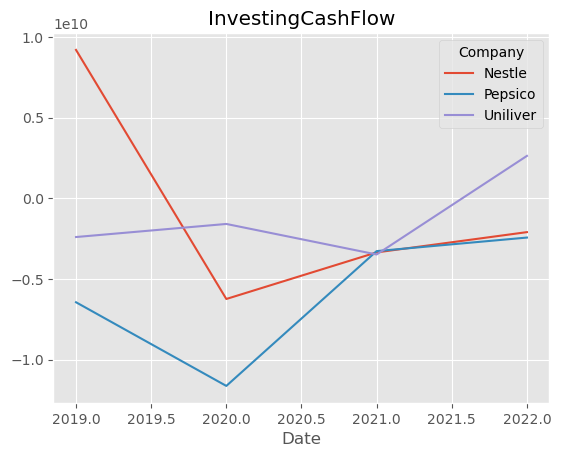

<Figure size 640x480 with 0 Axes>

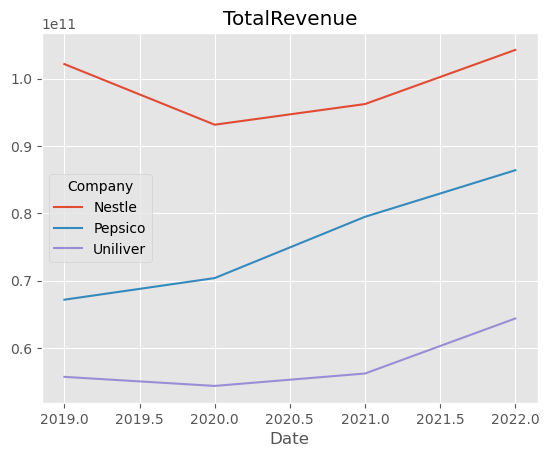

<Figure size 640x480 with 0 Axes>

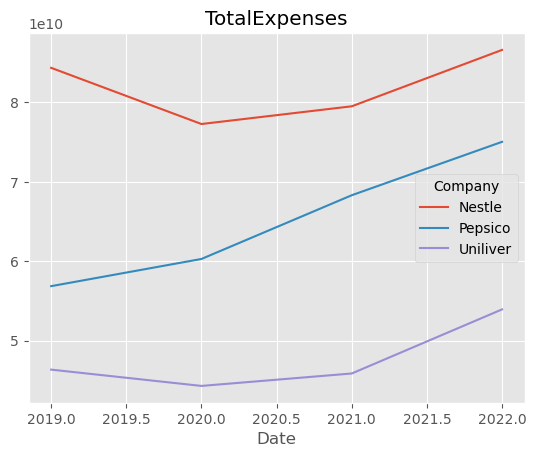

<Figure size 640x480 with 0 Axes>

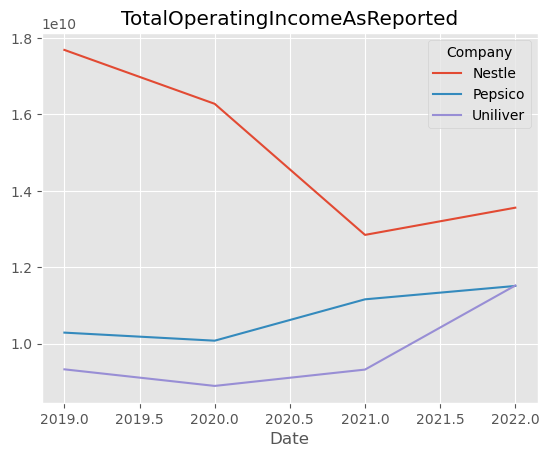

<Figure size 640x480 with 0 Axes>

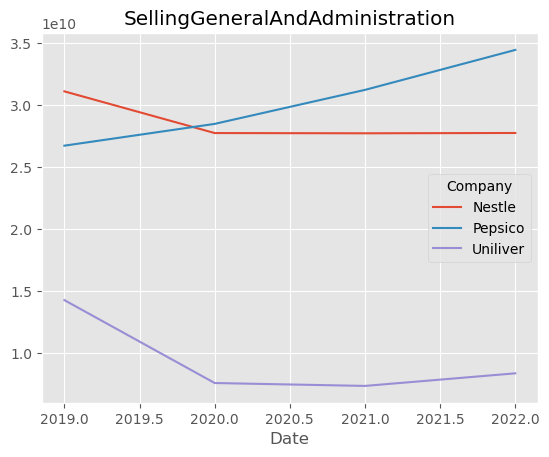

<Figure size 640x480 with 0 Axes>

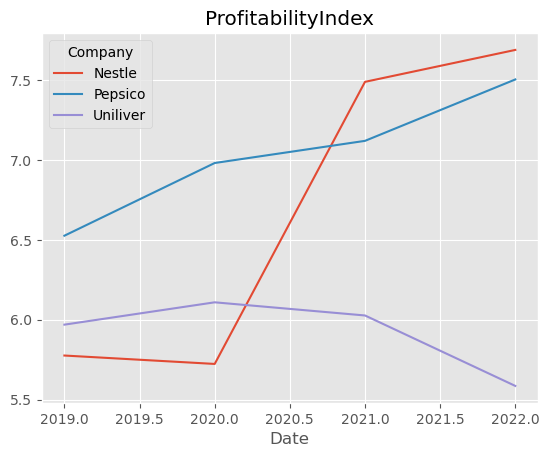

<Figure size 640x480 with 0 Axes>

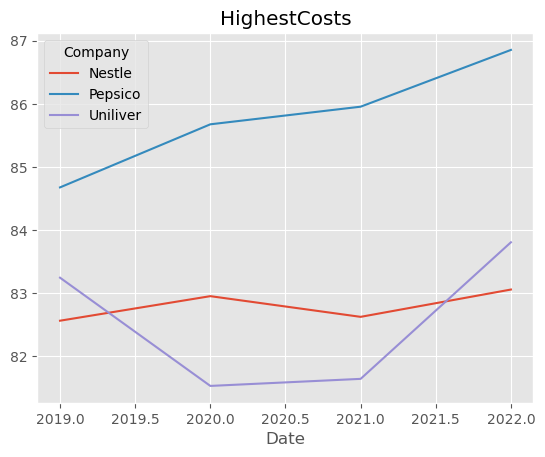

<Figure size 640x480 with 0 Axes>

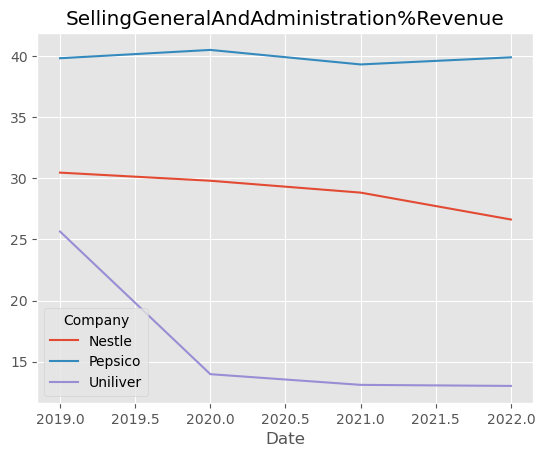

In [10]:
#Linear
for i in col:
    plt.figure();
    df[i].plot();
    plt.title(i);
    plt.xlabel("Date")
    # Show/save figure as desired.
    plt.show();
# Can show all

<Figure size 640x480 with 0 Axes>

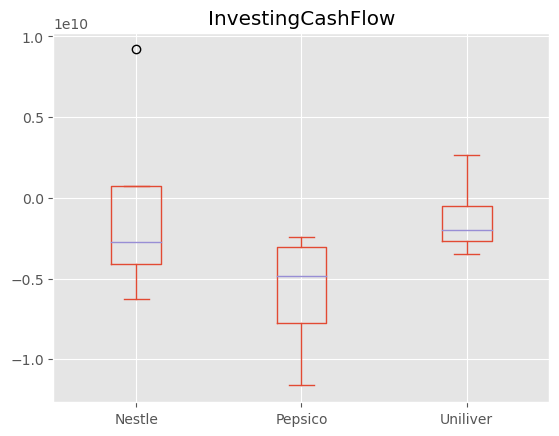

<Figure size 640x480 with 0 Axes>

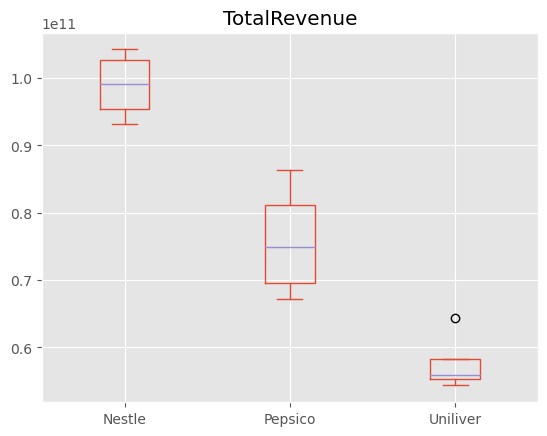

<Figure size 640x480 with 0 Axes>

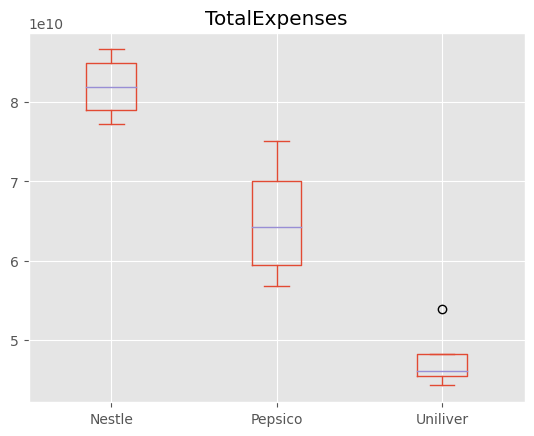

<Figure size 640x480 with 0 Axes>

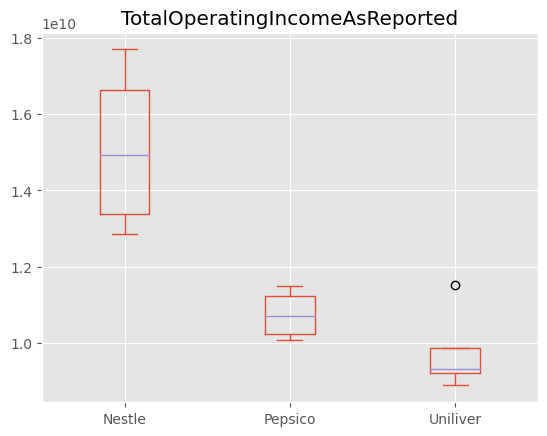

<Figure size 640x480 with 0 Axes>

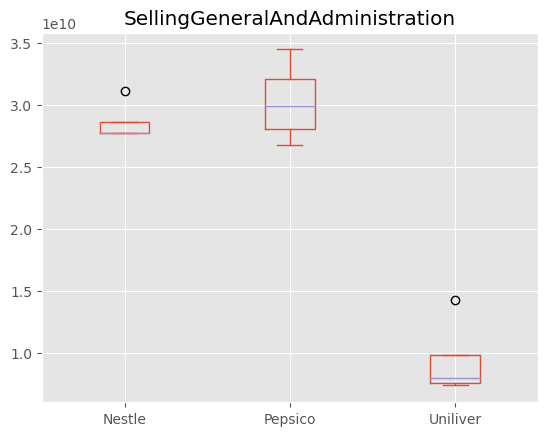

<Figure size 640x480 with 0 Axes>

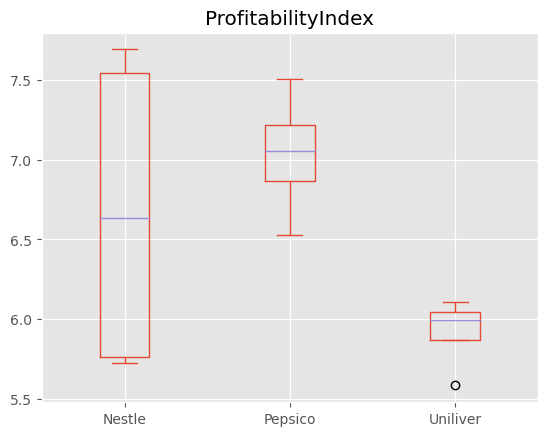

<Figure size 640x480 with 0 Axes>

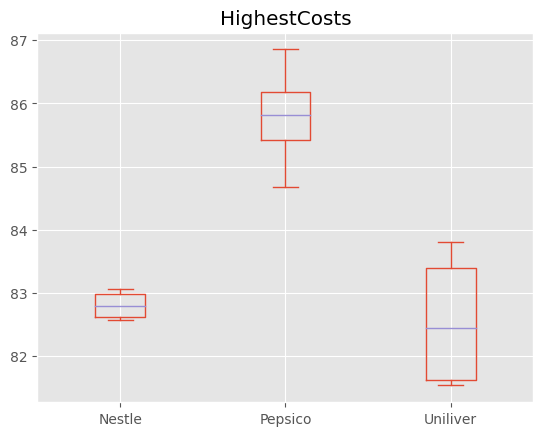

<Figure size 640x480 with 0 Axes>

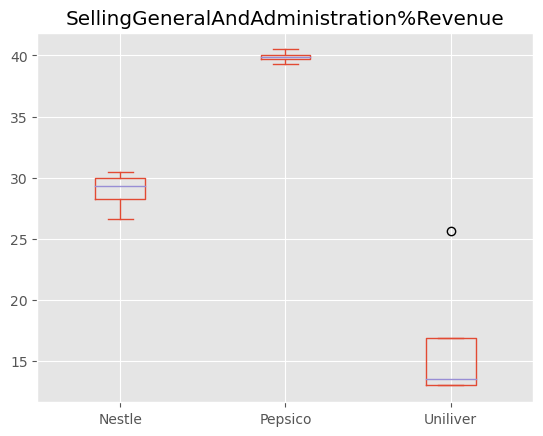

In [11]:
#boxplot
for i in col:
    plt.figure();
    df[i].plot(kind='box');
    plt.title(i);
    # Show/save figure as desired.
    plt.show();
# Can show all

<Figure size 640x480 with 0 Axes>

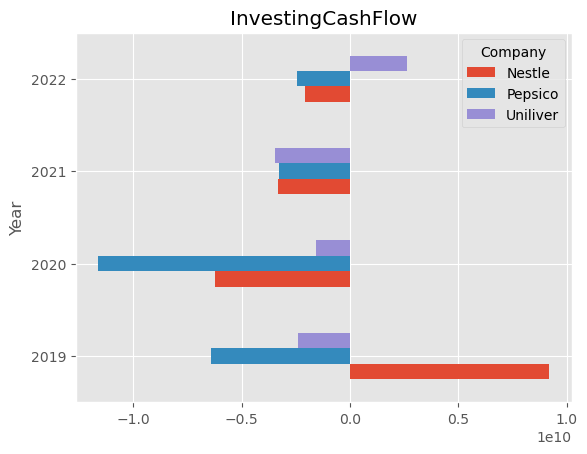

<Figure size 640x480 with 0 Axes>

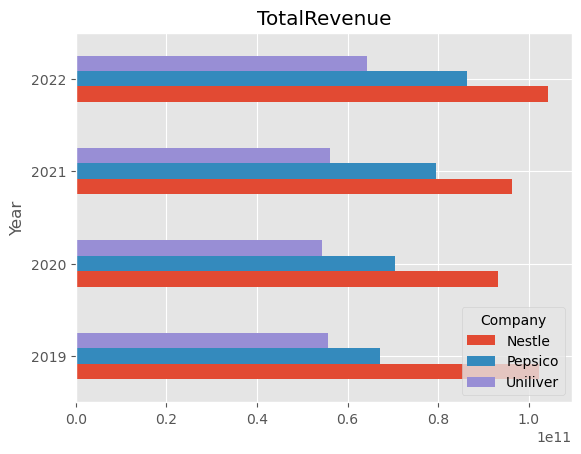

<Figure size 640x480 with 0 Axes>

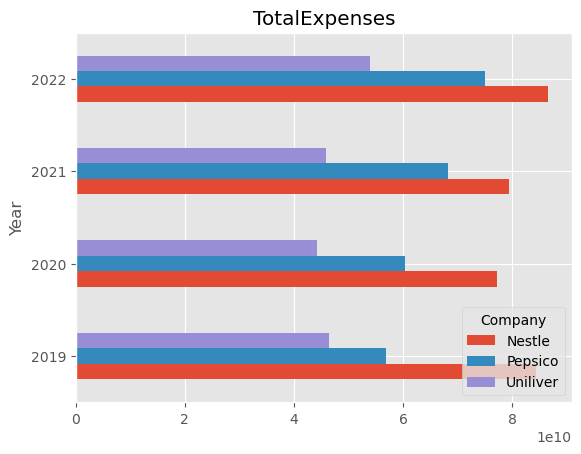

<Figure size 640x480 with 0 Axes>

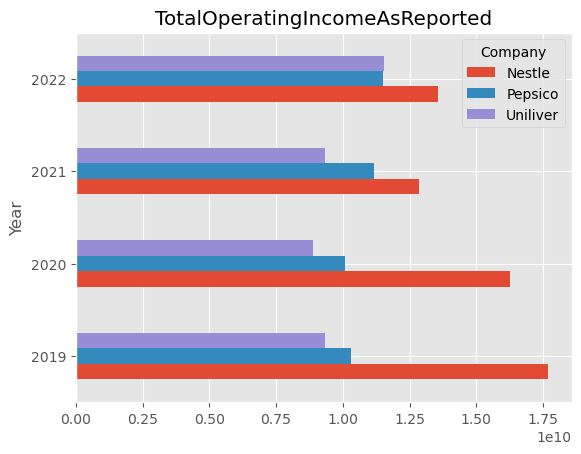

<Figure size 640x480 with 0 Axes>

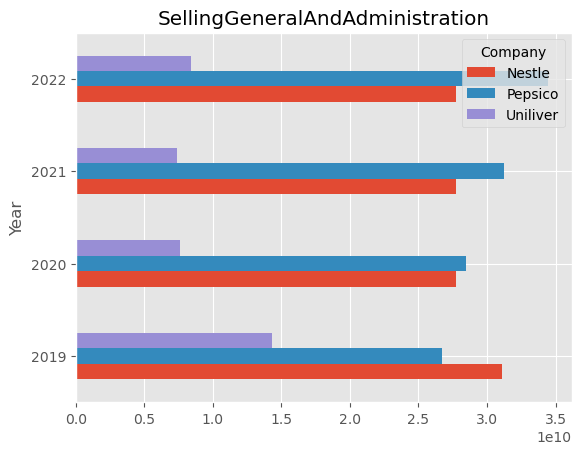

<Figure size 640x480 with 0 Axes>

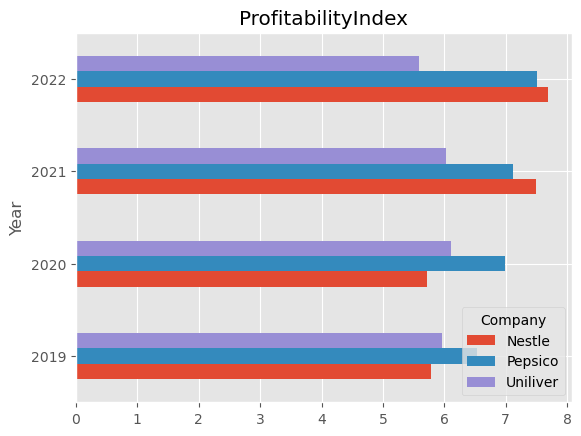

<Figure size 640x480 with 0 Axes>

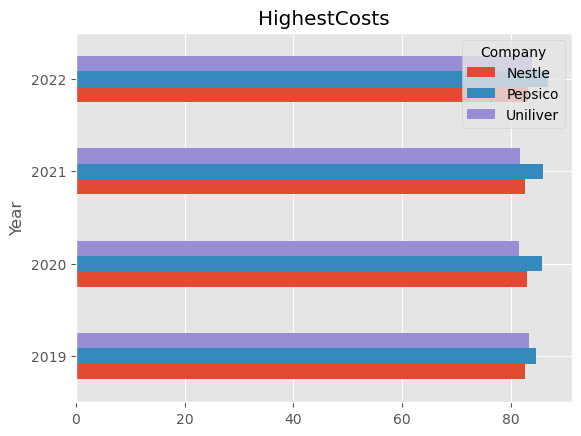

<Figure size 640x480 with 0 Axes>

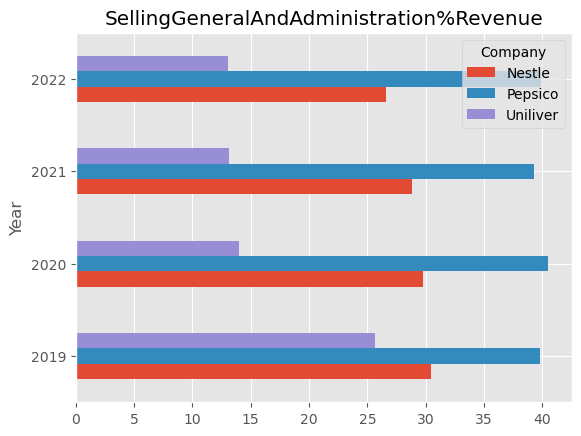

In [12]:
#bar
for i in col:
    plt.figure();
    df[i].plot(kind='barh');
    plt.title(i);
    # Show/save figure as desired.
    plt.show();
# Can show all